**Trained with xresnet architectire without transfer learning**

**later modified the model with mish activation function**
1. used total dataset of 62 classes


In [1]:
!pip install fastai wwf -q --upgrade

     |████████████████████████████████| 194kB 10.9MB/s 
     |████████████████████████████████| 61kB 5.9MB/s 
     |████████████████████████████████| 12.8MB 204kB/s 
     |████████████████████████████████| 776.8MB 24kB/s 
     |████████████████████████████████| 296kB 42.2MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *

In [4]:
path = Path('/content/drive/MyDrive/iiit delhi/train1')

**Augmentation used**
1. Flipping  = False
2. max_rotate = to rotate image up to 10degrees
3. zoom image using min_zoom and max_zoom values
4. max_lightning = applying lightining of probablity 0.2
5. pad_mode = applying padding (reflection of the image)
  

In [5]:
np.random.seed(6)

dataset = DataBlock(blocks = (ImageBlock,CategoryBlock),
                    #loading all images
                  get_items = get_image_files,
                  # dividing the dataset randomly into train=80% val=20%
                  splitter = RandomSplitter(),
                  # getting label from folder name
                  get_y = parent_label,
                  #transforming image size = 64
                  item_tfms=Resize(64),
                  #applying augmentation
                  batch_tfms=aug_transforms(do_flip=False, flip_vert=False, max_rotate=10.0, min_zoom=1.0,
                                            max_zoom=1.1, max_lighting=0.2, max_warp=0.2, 
                                            p_affine=0.75, p_lighting=0.75,pad_mode='reflection', min_scale=1.0))

loading dataset into dataloaders

In [6]:
dls = dataset.dataloaders(path)

visualizing dataset

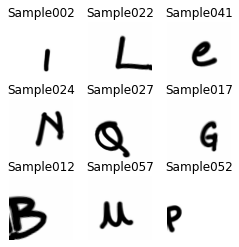

In [7]:
dls.show_batch(max_n=9, figsize=(4,4))

xresnet are based from bag of tricks paper which are implemented using fastai library
- reference - https://arxiv.org/abs/1812.01187

In [13]:
arch = xresnet50(pretrained=False)

architecture of xresnet50 

In [16]:
arch

XResNet(
  (0): ConvLayer(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): ResBlock(
      (convpath): Sequential(
        (0): ConvLayer(
          (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

we are loading our xresnet model here

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.0005754399462603033)

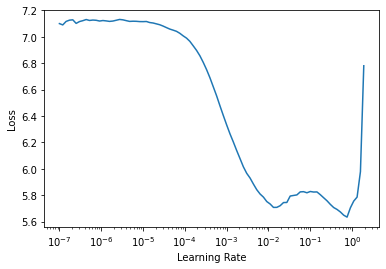

In [15]:
# for top_k_accuracy, k value is 5
learn = Learner(dls, model=arch, loss_func=LabelSmoothingCrossEntropy(), metrics=[top_k_accuracy, accuracy, error_rate])
#finding learning rate
learn.lr_find()


In [18]:
learn.fit(10, 2e-3)

epoch,train_loss,valid_loss,top_k_accuracy,accuracy,error_rate,time
0,4.306426,4.363246,0.229839,0.054435,0.945565,00:44
1,4.263346,4.267651,0.241935,0.040323,0.959677,00:43
2,4.245004,4.234149,0.252016,0.038306,0.961694,00:43
3,4.215594,4.187731,0.245968,0.056452,0.943548,00:43
4,4.173731,4.150283,0.272177,0.058468,0.941532,00:44
5,4.139087,4.102974,0.284274,0.062500,0.937500,00:43
6,4.098276,4.095746,0.270161,0.066532,0.933468,00:43
7,4.053877,4.199157,0.300403,0.086694,0.913306,00:43
8,4.008327,3.995894,0.377016,0.106855,0.893145,00:43
9,3.960705,3.899467,0.415323,0.096774,0.903226,00:43


In [20]:
learn.fit(10, 1e-3)

epoch,train_loss,valid_loss,top_k_accuracy,accuracy,error_rate,time
0,3.863788,3.849493,0.465726,0.116935,0.883065,00:44
1,3.853613,3.966265,0.342742,0.082661,0.917339,00:44
2,3.828678,3.992386,0.364919,0.100806,0.899194,00:44
3,3.801048,4.268793,0.286290,0.062500,0.937500,00:44
4,3.778329,3.741668,0.504032,0.145161,0.854839,00:44
5,3.755101,3.814323,0.457661,0.163306,0.836694,00:44
6,3.734390,3.710569,0.518145,0.169355,0.830645,00:44
7,3.715254,3.660242,0.538306,0.167339,0.832661,00:45
8,3.688784,3.634799,0.560484,0.163306,0.836694,00:44
9,3.663288,3.700057,0.502016,0.205645,0.794355,00:44


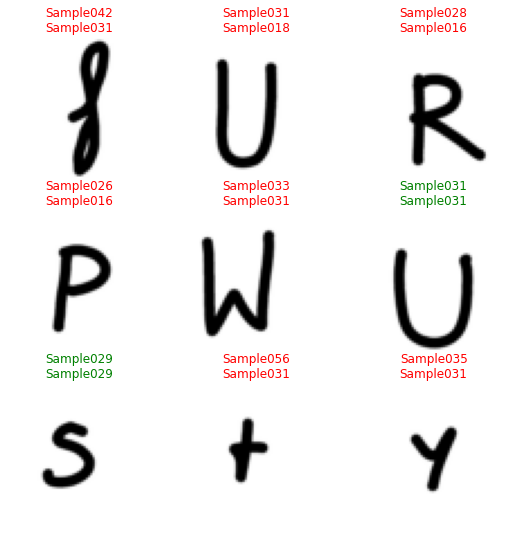

In [21]:
learn.show_results()

In [22]:
learn.save('model1-xresnet')
learn.export('model1-xresnet.pkl')

Plotting confusion matrix

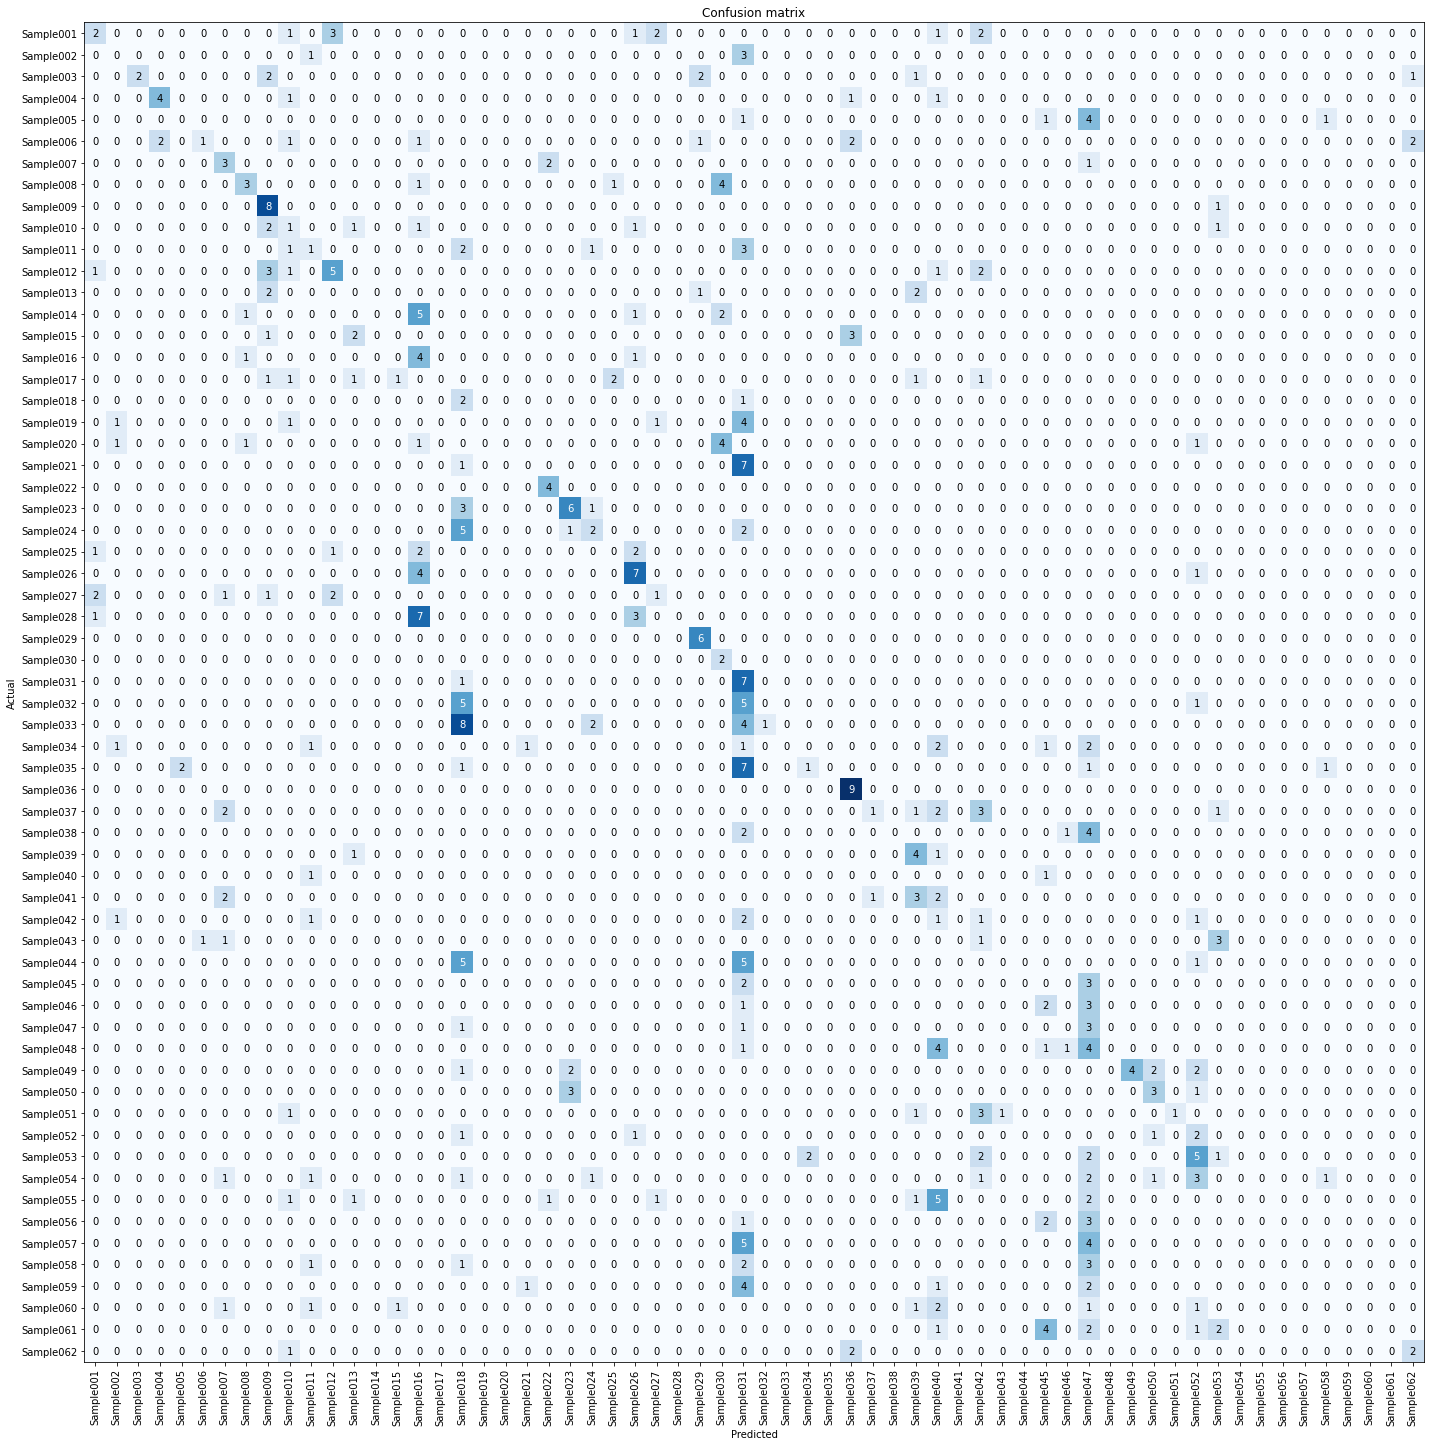

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(dls.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(20,20))


Now training the same dataset from dataloader with xresnet with mish activation function replaced

Mish activation fucntion with xresnet
- Mish activation function - https://arxiv.org/abs/1908.08681v1

In [24]:
arch = xresnet50(pretrained=False, act_cls=Mish)

In [25]:
#k=5
learn = Learner(dls, model=arch, loss_func=LabelSmoothingCrossEntropy(), metrics=[top_k_accuracy, accuracy, error_rate])


In [26]:
learn.fit_one_cycle(20, 2e-3)

epoch,train_loss,valid_loss,top_k_accuracy,accuracy,error_rate,time
0,5.863460,5.898402,0.326613,0.084677,0.915323,00:45
1,4.476616,3.394383,0.741935,0.379032,0.620968,00:44
2,3.471094,2.650742,0.911290,0.562500,0.437500,00:41
3,2.703660,2.275896,0.935484,0.618952,0.381048,00:42
4,2.261378,2.813739,0.810484,0.550403,0.449597,00:42
5,2.017751,1.932458,0.953629,0.725806,0.274194,00:42
6,1.825984,2.039823,0.967742,0.707661,0.292339,00:43
7,1.703214,1.924879,0.963710,0.719758,0.280242,00:42
8,1.605873,1.700114,0.975806,0.804435,0.195565,00:42
9,1.537288,2.043833,0.941532,0.687500,0.312500,00:42


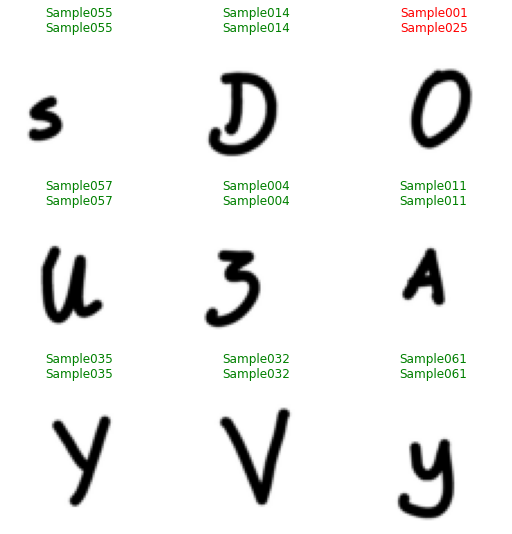

In [27]:
learn.show_results()

In [28]:
learn.save('model1-xresnet-mish')
learn.export('model1-xresnet-mish.pkl')

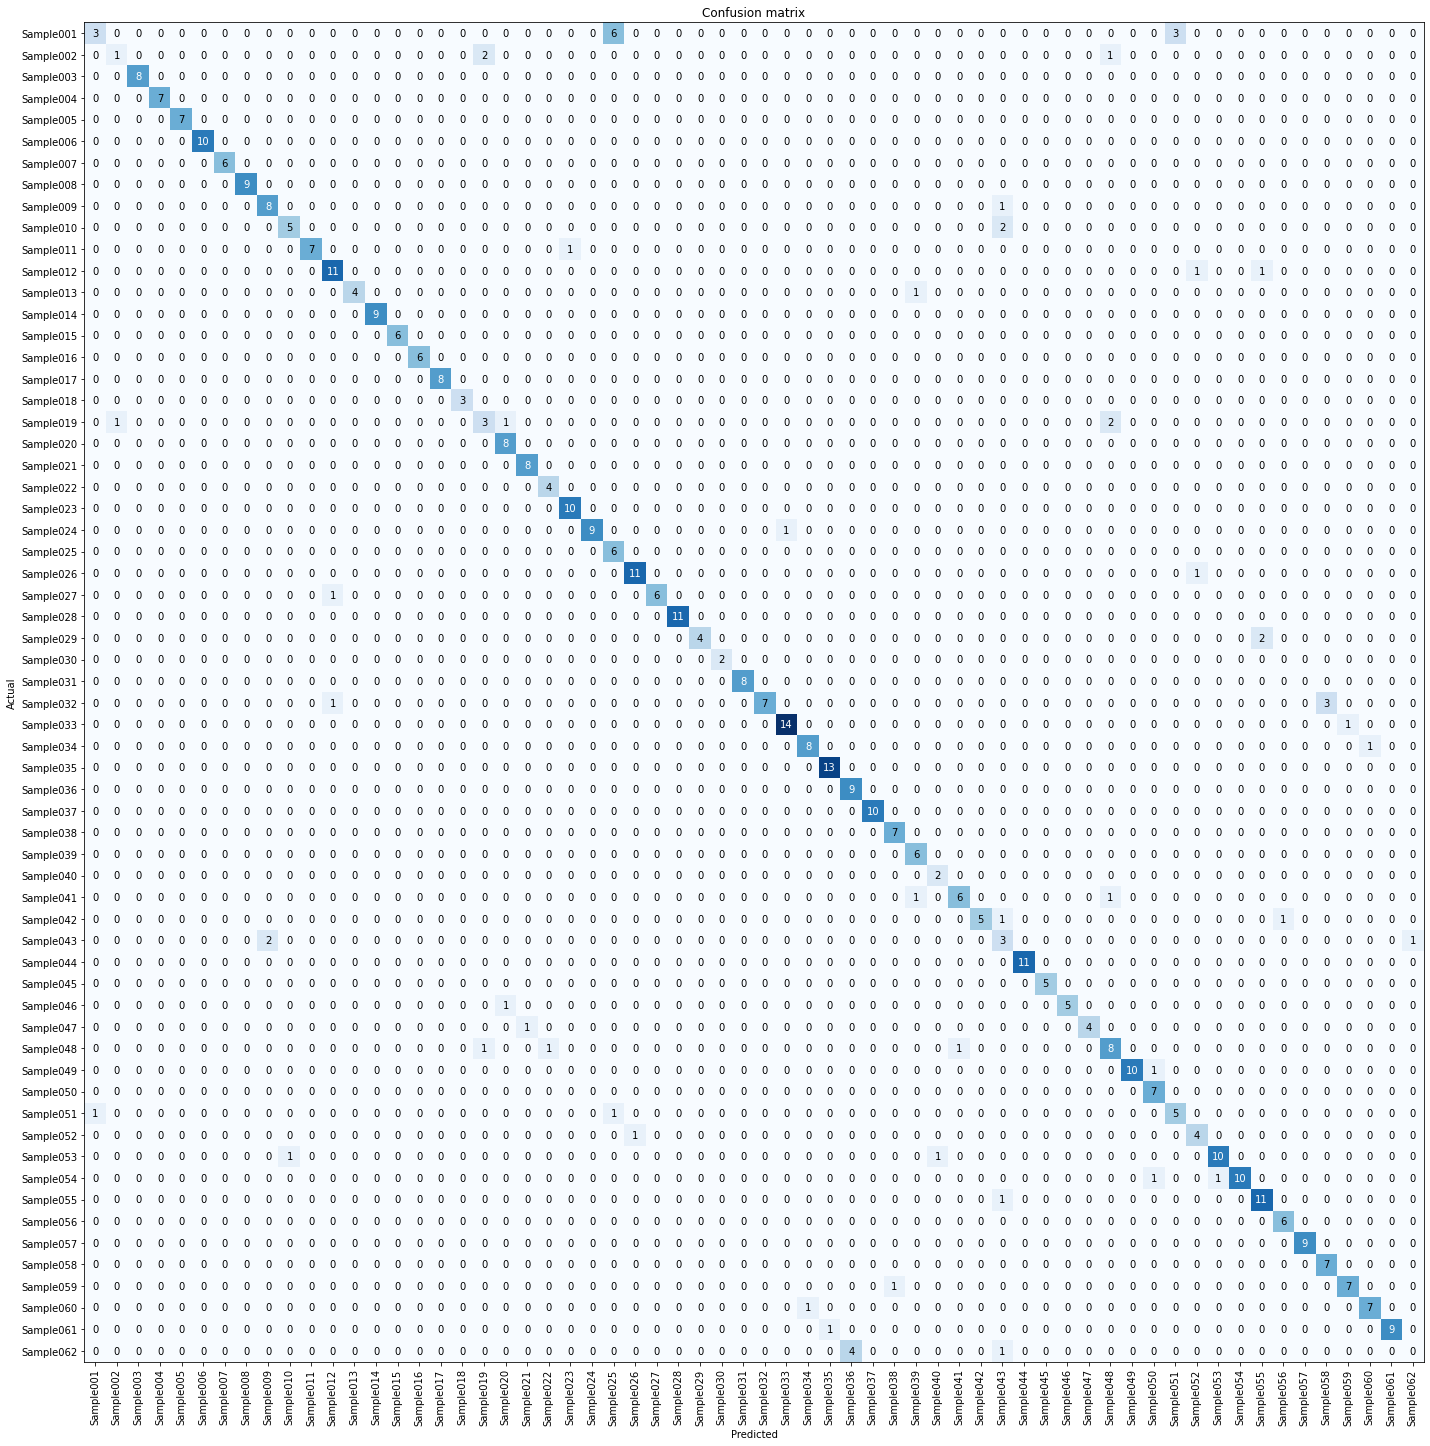

In [29]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(dls.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(20,20))
